In [1]:
!pip install cvxopt

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 435.7 kB/s eta 0:00:30
     --------------------------------------- 0.0/12.8 MB 388.9 kB/s eta 0:00:33
     --------------------------------------- 0.1/12.8 MB 409.6 kB/s eta 0:00:32
     --------------------------------------- 0.1/12.8 MB 351.4 kB/s eta 0:00:37
     --------------------------------------- 0.1/12.8 MB 409.6 kB/s eta 0:00:32
     --------------------------------------- 0.1/12.8 MB 399.4 kB/s eta 0:00:32
     --------------------------------------- 0.1/12.8 MB 404.6 kB/s eta 0:00:32
     --------------------------------------- 0.2/12.8 MB 382.3 kB/s eta 0:00:34
      -------------------------------------- 0.2/12.8 MB 402.6 kB/s eta 0:00:32
      -------------------------------------- 0.2/12.8 MB 406.0 kB/s eta 0:00:32
      -------------------------------------- 0.2/12.8 MB


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers

In [4]:
sd = pd.read_csv('stock_data_weak.csv')
print(sd)

          Date  General Electric  Chesapeake Energy   AT&T  Cisco Systems  \
0   12/31/2007             37.08              39.36  42.12          27.25   
1    3/31/2008             36.63              45.76  37.71          24.08   
2    6/30/2008             26.35              66.77  32.75          23.47   
3    9/30/2008             23.87              33.29  28.35          22.25   
4   12/31/2008             15.82              15.34  28.19          16.18   
5    3/31/2009             10.33              17.65  25.44          16.53   
6    6/30/2009             11.84              19.72  25.14          18.94   
7    9/30/2009             16.83              28.80  27.34          23.55   
8   12/31/2009             15.27              26.36  28.29          24.10   
9    3/31/2010             18.21              23.52  25.90          26.52   
10   6/30/2010             14.47              21.47  24.35          21.52   
11   9/30/2010             16.46              22.66  28.78          22.05   

In [5]:
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []  # List to store portfolio returns
    port_volatility = []  # List to store portfolio volatilities
    stock_weights = []  # List to store asset weights in each portfolio
    
    selected = expected_returns.index  
    
    num_assets = len(selected) 
    num_portfolios = 5000 
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)  
        weights /= np.sum(weights) 
        returns = np.dot(weights, expected_returns)  
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
        
    portfolio = {'Returns': port_returns, 'Volatility': port_volatility}
    
    for counter, symbol in enumerate(selected):
        portfolio[symbol + 'Weight'] = [Weight[counter] for Weight in stock_weights]
        
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock + 'Weight' for stock in selected]
    
    df = df[column_order]
    
    return df


def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n,1))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks



In [8]:
selected = list(sd.columns[1:])
returns_quarterly = sd[selected].pct_change()

In [9]:
expected_returns = returns_quarterly.mean()

In [10]:
cov_quarterly = returns_quarterly.cov()

In [11]:
random_portfolios = return_portfolios(expected_returns, cov_quarterly)

<Axes: xlabel='Volatility', ylabel='Returns'>

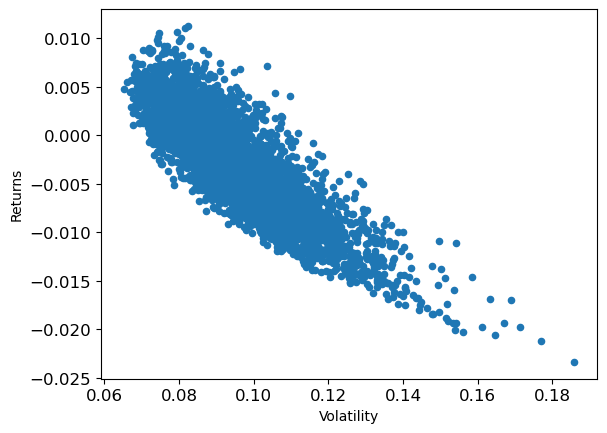

In [14]:
random_portfolios.plot.scatter(x = 'Volatility', y = 'Returns', fontsize=12)

In [15]:
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

     pcost       dcost       gap    pres   dres
 0:  2.3517e-03 -1.0183e+00  1e+00  1e-16  3e+00
 1:  1.8118e-03 -2.8254e-02  3e-02  8e-17  8e-02
 2: -1.4950e-02 -1.9458e-02  5e-03  6e-16  2e-17
 3: -1.7780e-02 -1.7871e-02  9e-05  2e-16  2e-17
 4: -1.7834e-02 -1.7835e-02  9e-07  2e-19  2e-17
 5: -1.7835e-02 -1.7835e-02  9e-09  2e-16  3e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3950e-03 -1.0182e+00  1e+00  3e-16  3e+00
 1:  1.8529e-03 -2.8227e-02  3e-02  9e-17  8e-02
 2: -1.4853e-02 -1.9394e-02  5e-03  2e-16  2e-17
 3: -1.7699e-02 -1.7791e-02  9e-05  2e-16  1e-17
 4: -1.7756e-02 -1.7757e-02  9e-07  2e-19  9e-18
 5: -1.7756e-02 -1.7756e-02  9e-09  2e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.4435e-03 -1.0182e+00  1e+00  2e-16  3e+00
 1:  1.8989e-03 -2.8196e-02  3e-02  7e-17  8e-02
 2: -1.4745e-02 -1.9323e-02  5e-03  1e-16  1e-17
 3: -1.7609e-02 -1.7701e-02  9e-05  2e-16  1e-17
 4: -1.7667e-02 -1.7668e

 6:  2.8786e-01  2.8786e-01  9e-08  6e-17  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.1652e-01 -7.5971e-01  7e+00  2e+00  3e+00
 1:  3.8299e-01 -3.6539e-01  7e-01  3e-16  3e-16
 2:  3.4308e-01  2.7235e-01  7e-02  1e-16  2e-16
 3:  3.2503e-01  3.2089e-01  4e-03  6e-17  3e-16
 4:  3.2367e-01  3.2342e-01  2e-04  1e-16  2e-16
 5:  3.2364e-01  3.2364e-01  6e-06  6e-17  3e-16
 6:  3.2364e-01  3.2364e-01  6e-08  6e-17  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.5026e-01 -7.2595e-01  8e+00  2e+00  3e+00
 1:  4.1989e-01 -3.2462e-01  7e-01  2e-16  4e-16
 2:  3.8082e-01  3.1375e-01  7e-02  3e-17  5e-16
 3:  3.6488e-01  3.6119e-01  4e-03  1e-16  1e-16
 4:  3.6381e-01  3.6359e-01  2e-04  6e-17  3e-16
 5:  3.6379e-01  3.6378e-01  4e-06  2e-16  2e-16
 6:  3.6379e-01  3.6379e-01  4e-08  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.8810e-01 -6.8789e-01  8e+00  2e+00  3e+00


Text(0.5, 1.0, 'Efficient Frontier')

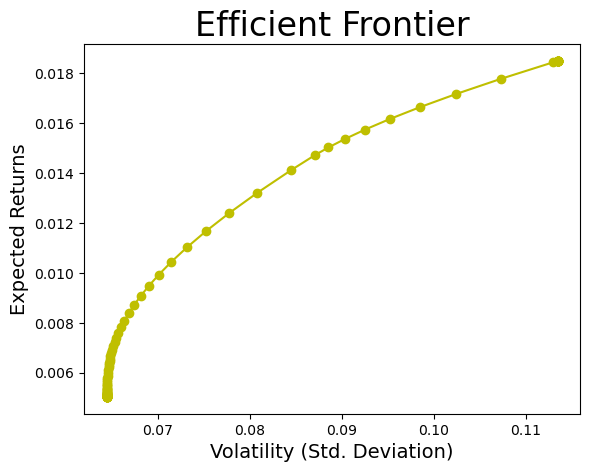

In [16]:
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns', fontsize=14)
plt.xlabel('Volatility (Std. Deviation)', fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

     pcost       dcost       gap    pres   dres
 0:  2.3517e-03 -1.0183e+00  1e+00  1e-16  3e+00
 1:  1.8118e-03 -2.8254e-02  3e-02  8e-17  8e-02
 2: -1.4950e-02 -1.9458e-02  5e-03  6e-16  2e-17
 3: -1.7780e-02 -1.7871e-02  9e-05  2e-16  2e-17
 4: -1.7834e-02 -1.7835e-02  9e-07  2e-19  2e-17
 5: -1.7835e-02 -1.7835e-02  9e-09  2e-16  3e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3950e-03 -1.0182e+00  1e+00  3e-16  3e+00
 1:  1.8529e-03 -2.8227e-02  3e-02  9e-17  8e-02
 2: -1.4853e-02 -1.9394e-02  5e-03  2e-16  2e-17
 3: -1.7699e-02 -1.7791e-02  9e-05  2e-16  1e-17
 4: -1.7756e-02 -1.7757e-02  9e-07  2e-19  9e-18
 5: -1.7756e-02 -1.7756e-02  9e-09  2e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.4435e-03 -1.0182e+00  1e+00  2e-16  3e+00
 1:  1.8989e-03 -2.8196e-02  3e-02  7e-17  8e-02
 2: -1.4745e-02 -1.9323e-02  5e-03  1e-16  1e-17
 3: -1.7609e-02 -1.7701e-02  9e-05  2e-16  1e-17
 4: -1.7667e-02 -1.7668e

 2:  2.5255e-01  1.7481e-01  8e-02  2e-16  5e-16
 3:  2.2985e-01  2.2436e-01  5e-03  2e-16  8e-17
 4:  2.2760e-01  2.2725e-01  3e-04  1e-16  2e-16
 5:  2.2753e-01  2.2752e-01  2e-05  2e-16  1e-16
 6:  2.2753e-01  2.2753e-01  2e-07  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5946e-01 -8.1609e-01  7e+00  2e+00  3e+00
 1:  3.1882e-01 -4.3346e-01  8e-01  4e-16  4e-16
 2:  2.7941e-01  2.0331e-01  8e-02  1e-16  4e-16
 3:  2.5798e-01  2.5292e-01  5e-03  6e-17  2e-16
 4:  2.5601e-01  2.5570e-01  3e-04  2e-16  4e-16
 5:  2.5597e-01  2.5595e-01  1e-05  4e-17  2e-16
 6:  2.5597e-01  2.5597e-01  1e-07  6e-17  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.8639e-01 -7.8962e-01  7e+00  2e+00  3e+00
 1:  3.4941e-01 -4.0152e-01  8e-01  4e-16  5e-16
 2:  3.0944e-01  2.3568e-01  7e-02  2e-16  5e-16
 3:  2.8957e-01  2.8496e-01  5e-03  2e-16  2e-16
 4:  2.8790e-01  2.8761e-01  3e-04  2e-16  1e-16
 5:  2.8786e-01  2.8785

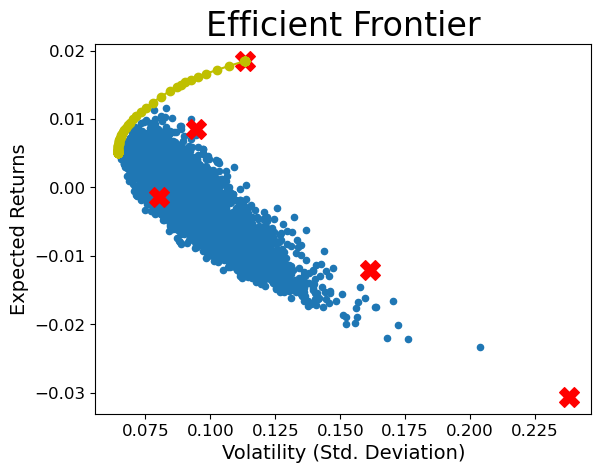

In [17]:
selected = list(sd.columns[1:])
returns_quarterly = sd[selected].pct_change()

# Find the expected returns
expected_returns = returns_quarterly.mean()

# Find the covariance
cov_quarterly = returns_quarterly.cov()

# Find a set of random portfolios
random_portfolios = return_portfolios(expected_returns, cov_quarterly)

# Plot the set of random portfolios
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

# Calculate the set of portfolios on the EF
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

# Plot the set of portfolios on the EF
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

# Compare the set of portfolios on the EF
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

plt.show()

In [18]:
#We change the path to determine the efficient frontier foe the different datsets

     pcost       dcost       gap    pres   dres
 0: -1.0662e-02 -1.0359e+00  1e+00  0e+00  3e+00
 1: -1.1534e-02 -4.5915e-02  3e-02  1e-16  1e-01
 2: -3.2498e-02 -3.8737e-02  6e-03  1e-16  2e-03
 3: -3.4247e-02 -3.4697e-02  4e-04  1e-16  1e-04
 4: -3.4442e-02 -3.4469e-02  3e-05  2e-16  5e-07
 5: -3.4446e-02 -3.4446e-02  4e-07  1e-16  5e-09
 6: -3.4446e-02 -3.4446e-02  4e-09  1e-16  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0582e-02 -1.0358e+00  1e+00  1e-16  3e+00
 1: -1.1451e-02 -4.5792e-02  3e-02  7e-17  1e-01
 2: -3.2227e-02 -3.8492e-02  6e-03  2e-16  2e-03
 3: -3.4012e-02 -3.4437e-02  4e-04  9e-18  8e-05
 4: -3.4193e-02 -3.4213e-02  2e-05  2e-16  7e-07
 5: -3.4196e-02 -3.4196e-02  2e-07  2e-16  7e-09
 6: -3.4196e-02 -3.4196e-02  2e-09  1e-16  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0492e-02 -1.0357e+00  1e+00  0e+00  3e+00
 1: -1.1358e-02 -4.5653e-02  3e-02  9e-17  1e-01
 2: -3.1924e-02 -3.8217e

 1:  2.6470e-01 -5.4776e-01  8e-01  4e-16  6e-16
 2:  2.1725e-01  1.2090e-01  1e-01  2e-16  5e-16
 3:  1.8584e-01  1.7470e-01  1e-02  2e-16  4e-16
 4:  1.8000e-01  1.7924e-01  8e-04  2e-16  2e-16
 5:  1.7962e-01  1.7958e-01  5e-05  3e-17  1e-16
 6:  1.7959e-01  1.7959e-01  6e-07  2e-16  8e-17
 7:  1.7959e-01  1.7959e-01  6e-09  8e-17  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1644e-01 -8.6031e-01  1e+01  3e+00  4e+00
 1:  2.8694e-01 -5.1934e-01  8e-01  4e-16  7e-16
 2:  2.3814e-01  1.4476e-01  9e-02  2e-16  4e-16
 3:  2.0786e-01  1.9764e-01  1e-02  1e-16  2e-16
 4:  2.0256e-01  2.0188e-01  7e-04  3e-17  2e-16
 5:  2.0221e-01  2.0218e-01  3e-05  1e-16  3e-16
 6:  2.0219e-01  2.0219e-01  4e-07  2e-16  2e-16
 7:  2.0219e-01  2.0219e-01  4e-09  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3699e-01 -8.3803e-01  1e+01  3e+00  4e+00
 1:  3.1129e-01 -4.8793e-01  8e-01  4e-16  8e-16
 2:  2.6152e-01  1.7159

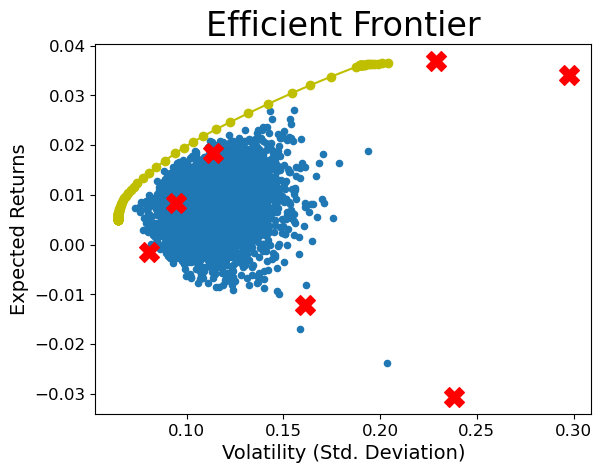

In [20]:
sd2 = pd.read_csv('stock_data2.csv')
selected = list(sd2.columns[1:])
returns_quarterly = sd2[selected].pct_change()
expected_returns = returns_quarterly.mean()
cov_quarterly = returns_quarterly.cov()
random_portfolios = return_portfolios(expected_returns, cov_quarterly)
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)
plt.show()

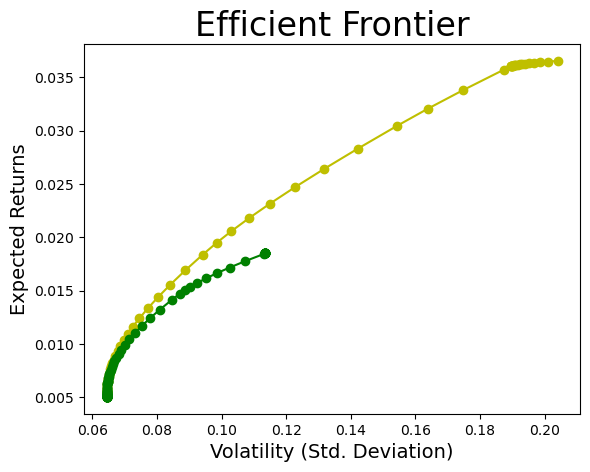

In [22]:
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
sd3 = pd.read_csv('weak_risks_returns.csv')
plt.plot(sd3['Risks'], sd3['Returns'], 'g-o')

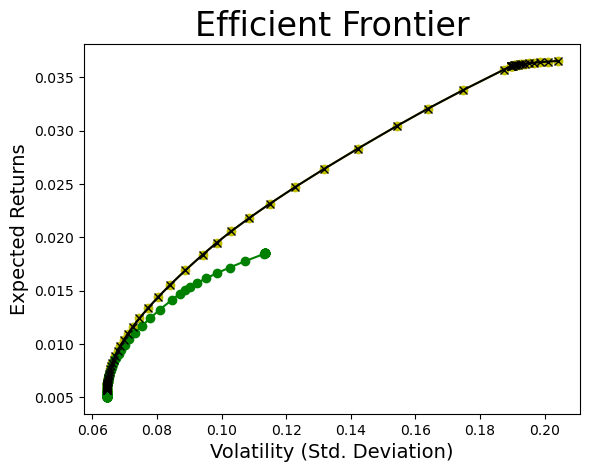

In [24]:
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
sd4 = pd.read_csv('weak_risks_returns.csv')
plt.plot(sd4['Risks'], sd4['Returns'], 'g-o')
sd5 = pd.read_csv('strong_risks_returns.csv')
plt.plot(sd5['Risks'], sd5['Returns'], 'k-x')

In [25]:
#Informing portfolio decisions about assets of 10 stocks from a different dataset

PFE    0.015530
TGT    0.014783
M      0.021962
VZ     0.004856
JPM    0.034781
MRO   -0.008010
KO    -0.002050
PG     0.004132
CVS    0.016124
HPQ   -0.000237
dtype: float64
          PFE       TGT         M        VZ       JPM       MRO        KO  \
PFE  0.010005  0.001738  0.005978  0.004071  0.007016  0.009721  0.002086   
TGT  0.001738  0.012874  0.015762  0.002188  0.007805  0.002239  0.002534   
M    0.005978  0.015762  0.038909  0.002804  0.016439  0.015110  0.005189   
VZ   0.004071  0.002188  0.002804  0.006958 -0.000407  0.005276  0.002586   
JPM  0.007016  0.007805  0.016439 -0.000407  0.023837  0.013848  0.002979   
MRO  0.009721  0.002239  0.015110  0.005276  0.013848  0.043166 -0.001516   
KO   0.002086  0.002534  0.005189  0.002586  0.002979 -0.001516  0.011021   
PG   0.004297  0.003148  0.005853  0.002094  0.006364  0.002834  0.001255   
CVS  0.004300  0.005384  0.012501  0.002052  0.005041  0.003689  0.003223   
HPQ  0.006996  0.007774  0.018937  0.003076  0.011523  

 3:  2.7761e-01  2.7372e-01  4e-03  4e-17  2e-16
 4:  2.7654e-01  2.7644e-01  9e-05  3e-17  1e-16
 5:  2.7652e-01  2.7652e-01  9e-07  1e-16  1e-16
 6:  2.7652e-01  2.7652e-01  9e-09  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.9212e-01 -7.9302e-01  8e+00  2e+00  3e+00
 1:  3.5453e-01 -3.9904e-01  8e-01  3e-16  4e-16
 2:  3.2188e-01  2.5010e-01  7e-02  1e-16  3e-16
 3:  3.1251e-01  3.0904e-01  3e-03  1e-16  2e-16
 4:  3.1175e-01  3.1167e-01  8e-05  1e-16  2e-16
 5:  3.1174e-01  3.1174e-01  8e-07  1e-16  3e-16
 6:  3.1174e-01  3.1174e-01  8e-09  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.2505e-01 -7.5832e-01  8e+00  2e+00  3e+00
 1:  3.8884e-01 -3.5708e-01  7e-01  4e-16  9e-16
 2:  3.5905e-01  2.9177e-01  7e-02  6e-17  3e-16
 3:  3.5174e-01  3.4864e-01  3e-03  2e-16  5e-16
 4:  3.5125e-01  3.5119e-01  7e-05  2e-16  2e-16
 5:  3.5125e-01  3.5125e-01  7e-07  1e-17  3e-16
 6:  3.5125e-01  3.5125

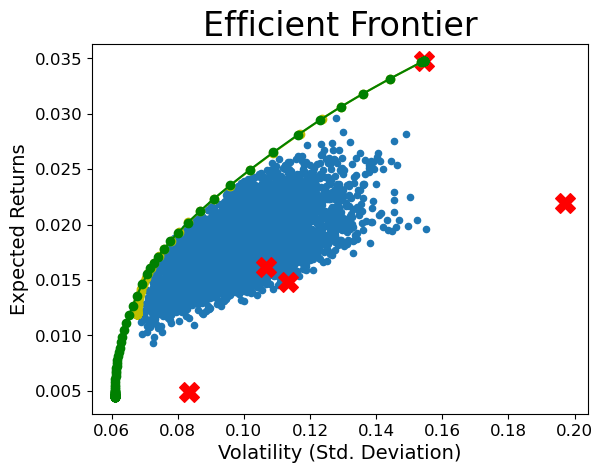

In [27]:
sd6 = pd.read_csv('stock_data3.csv')
selected = list(sd6.columns[1:])
print(sd6[selected].pct_change().mean())
print(sd6[selected].pct_change().cov())
#opting only some of the selected stocks out of the ten
selected = ['TGT', 'CVS', 'M', 'VZ', 'JPM']
returns_quarterly = sd6[selected].pct_change()
expected_returns = returns_quarterly.mean() 
cov_quarterly = returns_quarterly.cov()
random_portfolios = return_portfolios(expected_returns, cov_quarterly) 
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
#Compare the set of portfolios on the EF
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

#All 10 stocks EF calculated
sd7 = pd.read_csv('all_ten.csv')
plt.plot(sd7['Risks'],sd7['Returns'], 'g-o')
plt.show()

#Conclusion
We began by loading historical stock data and deriving key statistical measures, shedding light on the average returns and covariance structure of the selected assets. This insight forms the basis for our subsequent analysis.

Next, we delved into the realm of portfolio optimization by constructing the efficient frontier. Through a meticulous process of random portfolio simulations, we uncovered the intricate relationship between risk and reward. This visualization equips us with the ability to make informed decisions about portfolio allocations based on our risk preferences.

Furthermore, by applying advanced optimization, we identified the optimal portfolio that strikes the ideal balance between returns and risk. This is represented by the point on the efficient frontier with the highest Sharpe ratio, embodying the essence of effective asset allocation.

In a broader context, this notebook showcases the integration of data analysis, financial theory, and coding prowess. The resulting efficient frontier not only aids in portfolio construction but also cultivates a deeper understanding of the dynamics at play within the financial markets.

As investors and analysts continue to navigate the complexities of finance, the techniques demonstrated here offer a valuable toolkit for making more informed investment decisions. By blending empirical data analysis with mathematical optimization, we can confidently stride towards more robust, balanced, and resilient investment strategies.